# Advance Pipeline Land Detection
In the Previous project, Canny edge detection and Hough Transformation have limitations on handling shadows, and the constant threshold would not play well with a constantly changing driving environment. A more robust image process logic is require to get a good lane detecting result

## Road Map to a More Robust Lane Finding Algorithms 
The approach would be shown in the following steps
1. Camera Calibration and Distortion Correction
2. Color and Gradient Threshold Filter
3. Perspective Transform Calculation
4. Sliding Window Lane Line Finding
5. Curvature Measurement

## Import
I combine all the function from previous notbook into a python script so that I can import all the function here to simplify and only highlight the lane finding logic here


In [1]:
from frame_process import *

## Line Class
First let's define the a class to hold the all the status of the line.
This would be declare as a golbal variables and can be access across functions

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line\
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # Confident level, calculated after find the line poly
        self.confident = 0
        # Fail to detect line compare previous result
        self.fail_count = 0
        # distance in pixels of vehicle center from the line
        self.line_to_center = None
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels this should never change base on the same resolution
        self.ploty = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')


## Curvature Calculation and polynomial fit the line
Here I combined polynomial fit with curvature calcuation into one fucntion. This function will take x and y coordinates and calculate the polynomial coefficients and curvature in meters.

In [3]:
def fit_one_line(img_shape, y, x, ploty):
    """
    :param img_shape: process image shape
    :param y: collection of y coordinates
    :param x: collection of x coordinates
    :param ploty: A uniformed y coordinates for plotting
    :return: fitted x for easy plotting
            and polynomial coefficient both in pixel and meter
    """
    # it a second order polynomial to each with np.polyfit()
    fit = np.polyfit(y, x, 2)

    # Calcuated X coordinate using ploynomial coefficient and ploty
    fitx = fit[0] * ploty ** 2 + fit[1] * ploty + fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3 / 80
    xm_per_pix = 3.7 / 570

    # calculate polynomials in meters
    fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img_shape[0]

    # Implement the calculation of R_curve (radius of curvature)
    curve_rad = (1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5 / np.absolute(
        2 * fit_cr[0])
    return fitx, fit, curve_rad


## Sliding Window Lane Finding
Next, I define a fucntion that uses sliding window algorithm to process the binary image, which is the output of our image filter process. 
`find_lane_pixels` is able to run single lane line and run all lane lines options. In the future code, I will process left and right lane line separately since to reduce run time.

In [4]:
def find_lane_pixels(binary_warped, run_left=False, run_all=False, plot=False):
    # Logic to setup which line to run
    left_run = run_left or run_all
    right_run = not run_left or run_all
    
    if plot:
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Create a uniformed y coordinates for plotting
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[1] - 1, img_shape[0])
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        if left_run:
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            # Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            # If found > minpix pixels, recenter next window
            # (`right` or `leftx_current`) on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if right_run:
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            right_lane_inds.append(good_right_inds)
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if plot:
             # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

    if left_run:
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        left_fitx, left_fit, left_curve = fit_one_line(img_shape, lefty, leftx, ploty)

    if right_run:
        try:
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
        # Extract right line pixel position
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        right_fitx, right_fit, right_curve = fit_one_line(img_shape, righty, rightx, ploty)

    ## Visualization ##
    # Draw the windows on the visualization image if the plot flag is set
    if plot:
    
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
    # Logic to return correct variables
    if run_all:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, [left_curve, right_curve]
    else:
        if run_left:
            return left_fitx, ploty, left_fit, left_curve
        else:
            return right_fitx, ploty, right_fit, right_curve

[3063.683260679166, 52318.14655115999]


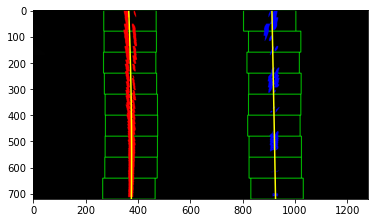

In [5]:
# Test Code to show how find_lane_pixels works

straight_img = mpimg.imread('test_images/straight_lines1.jpg')
test_undist = undistort_img(straight_img)
test_binary_wrap = binary_wrap_img(test_undist)

left_fitx, right_fitx, ploty, left_fit, right_fit, curvatures = \
find_lane_pixels(test_binary_wrap,run_all=True,plot=True)
print(curvatures)

To save runtime, `find_lane_pixel` would only run when there is no previous result or previous lane finding failed. Once there is a successful lane detection before, we would only run search around previous poly fit lines.Below function is take previous ploynomial coeffieicent and search the pixels around that region instead of defining windows again.

In [6]:
def search_around_poly(binary_warped, run_left=False, run_all=False, plot=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    # Create a uniformed y coordinates for plotting
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[1] - 1, img_shape[0])

    # Logic to setup which line to run

    left_run = run_left or run_all
    right_run = not run_left or run_all

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    if left_run:
        left_lane_inds = ((nonzerox >= (left_line.current_fit[0] * nonzeroy ** 2 + left_line.current_fit[1] * nonzeroy +
                                        left_line.current_fit[2] - margin)) &
                          (nonzerox < (left_line.current_fit[0] * nonzeroy ** 2 + left_line.current_fit[1] * nonzeroy +
                                       left_line.current_fit[2] + margin))).nonzero()[0]
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        left_fitx, left_fit, left_curve = fit_one_line(img_shape, lefty, leftx, ploty)

    if right_run:
        right_lane_inds = \
            ((nonzerox >= (right_line.current_fit[0] * nonzeroy ** 2 + right_line.current_fit[1] * nonzeroy +
                           right_line.current_fit[2] - margin)) &
             (nonzerox < (right_line.current_fit[0] * nonzeroy ** 2 + right_line.current_fit[1] * nonzeroy +
                          right_line.current_fit[2] + margin))).nonzero()[0]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        right_fitx, right_fit, right_curve = fit_one_line(img_shape, righty, rightx, ploty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    if plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,
                                                                        ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin,
                                                                         ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        plt.imshow(result)

    # Logic to return correct variables
    if run_all:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, [left_curve, right_curve]
    else:
        if run_left:
            return left_fitx, ploty, left_fit, left_curve
        else:
            return right_fitx, ploty, right_fit, right_curve


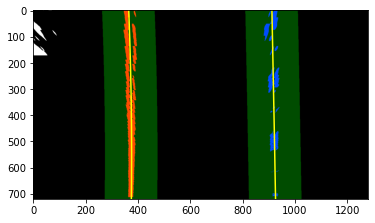

In [7]:
# Test Code for search around poly
# Delcare the line class and record previous ploy fit values
left_line = Line()
right_line = Line()
left_line.current_fit = left_fit
right_line.current_fit = right_fit

left_fitx, right_fitx, ploty, left_fit, right_fit, curvatures = \
search_around_poly(test_binary_wrap,run_all=True,plot=True)


In [8]:
# Draw_poly_fill uses the binary wrap and undist images and all the lane detection result to plot the final output image.
# 
def draw_poly_fill(binary_wrap, undist):
    # Draw unwarped the poly fill onto the image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_wrap).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fitx = left_line.bestx
    right_fitx = right_line.bestx
    ploty = left_line.ploty

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp, inverse=True)
    # cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Add Curvature results to the image
    left_curve_text = 'Left Radius of Curvature: ' + str(round(left_line.radius_of_curvature, 2)) + 'Meters'
    right_curve_text = 'Right Radius of Curvature: ' + str(round(right_line.radius_of_curvature, 2)) + 'Meters'
   
    result = cv2.putText(result, left_curve_text, (300, 100), cv2.FONT_HERSHEY_SIMPLEX,
                         1, (0, 255, 255), 2, cv2.LINE_AA)
    result = cv2.putText(result, right_curve_text, (300, 150), cv2.FONT_HERSHEY_SIMPLEX,
                         1, (0, 255, 255), 2, cv2.LINE_AA)

    # To dubug, put fail counter and confident level onto the image
    left_line_status = 'left: Fail counter:' + str(left_line.fail_count) + ' confident:' + str(left_line.confident)
    right_line_status = 'right: Fail counter:' + str(right_line.fail_count) + ' confident:' + str(right_line.confident)

    result = cv2.putText(result, left_line_status, (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
                         1, (0, 255, 255), 2, cv2.LINE_AA)
    result = cv2.putText(result, right_line_status, (600, 50), cv2.FONT_HERSHEY_SIMPLEX,
                         1, (0, 255, 255), 2, cv2.LINE_AA)
    return result

## Single Lane Detection logic
I decide to detect left and right lane separately. If there only one lane detection yield bad result, I don't have to recalculate the other lane and waste runtime on that. This will speed up the algorithm. 
This function will run for both left and right lane. To differentiate left and right in the lane finding logic, the flag called run_left is implemented. Below are how this logic works:
### Decide the complexity of the lane detection based on previous results
if previous result is lane detected and it has high confident, then uses search_around poly.
Otherwise, see if the fail counter is between 0 and 10, then perform sliding window search.
If the fail counter is greater, use a more complex color filtering logic by flag overdrive on` binary_wrap_img` function
### First time running
The very first iteration would have no previous result. Therefore, when radius of curvature is None, append the first iteration result to the line class without any checks. Also, during the complexity decision, with fail count = 0 and line.detected =  False, first iteration would use window sliding logic to pick up the lane line.
### Confident Check
For the confident check/sanity check, I check for radius of curvatures, line distance to the image center and polynomial coefficient against previous results. If the check passes, add 1 to the confident variable. When the confident is higher than 1, meaning the current result is good and then append it to the line result


In [9]:
def single_lane_detection(line, undist, run_left=False, fail_limit=10):
    # If the line detected previous iteration, preform search base on previous polynomial
    binary_wrap = binary_wrap_img(undist)
    if line.detected and line.confident >= 2:
        fitx, ploty, fit, curve = search_around_poly(binary_wrap, run_left)
    else:
        # If fail counter is less, preform simplify image filter and use sliding window to find lines
        if line.fail_count < fail_limit and line.fail_count >= 0:
            fitx, ploty, fit, curve = find_lane_pixels(binary_wrap, run_left)

        # If fail too many times, preform a more complex image filter and sliding window
        else:
            binary_wrap = binary_wrap_img(undist, overdrive=True)
            # Need to find a way to share this in case of the other line failed to detect as well
            fitx, ploty, fit, curve = find_lane_pixels(binary_wrap, run_left)

    # Calculate in meters
    current_line_to_center = abs(fitx[-1] - binary_wrap.shape[0] / 2)
    # if the radius is None meaning first time run, saving all the parameter in line
    if line.radius_of_curvature is None:
        line.detected = True
        line.radius_of_curvature = curve
        line.current_fit = fit
        line.recent_xfitted = fitx
        line.bestx = fitx
        line.allx = [fitx]
        line.line_to_center = current_line_to_center
        line.ploty = ploty
    else:
        # Here check for current results with previous.
        confident = 0
        if line.radius_of_curvature * (1 + 0.2) >= curve > line.radius_of_curvature * (1 - 0.2):
            confident += 1
        # Check line distance to the center
        if line.line_to_center * (1 + 0.1) >= current_line_to_center > \
                line.line_to_center * (1 - 0.1):
            confident += 1
        # Calculate fit coefficients difference
        if np.all(abs(fit) <= abs(line.current_fit) * (1 + 0.5)) and np.all(
                abs(fit) > abs(line.current_fit) * (1 - 0.5)):
            confident += 1
        # try not strict one first, can change later
        # If the confident level is great than 1, record the result into line
        if confident >= 1:
            # Append result into line
            line.detected = True
            line.radius_of_curvature = curve
            line.current_fit = fit
            line.recent_xfitted = fitx
            line.allx.append(fitx)
            line.line_to_center = current_line_to_center
            line.fail_count = 0

            # average x fitted only takes the most recent 20
            if len(line.allx) > 20:
                line.bestx = np.mean(line.allx[-20:], axis=0)
            else:
                line.bestx = np.mean(line.allx, axis=0)
        # else increase fail counter, discard current result
        else:
            line.fail_count += 1
        line.confident = confident
    return binary_wrap


## Video Processing
The video lane detection logic will un-distort the image and perform single lane detection logic to left and right lanes perspectively. Finally, it would call `draw_poly_fill` to fill the lane line with green shade and print out curvatures and debug message on the screen

In [10]:
def video_lane_detection(img):
    global left_line, right_line
    fail_allowed = 5

    # Un-distort image using Camera calibration data
    undist = undistort_img(img)

    # Left line detection
    binary_wrap = single_lane_detection(left_line, undist, True, fail_allowed)
    # Right line detection
    _ = single_lane_detection(right_line, undist, False, fail_allowed)


    result_img = draw_poly_fill(binary_wrap, undist )
    return result_img

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_line = Line()
right_line = Line()

output = 'output_video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('../challenge_video.mp4').subclip(0, 3)
clip2 = VideoFileClip('project_video.mp4')
project_clip = clip2.fl_image(video_lane_detection)
%time project_clip.write_videofile(output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_video/project_video.mp4.
Moviepy - Writing video output_video/project_video.mp4




t:   0%|          | 2/1260 [05:12<03:11,  6.56it/s, now=None]   

Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))